In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matrixprofile as mp
import datetime as dt
import matplotlib.dates as dates
import matplotlib.pyplot as plt

In [2]:
# A commonly used PyPlot theme 
plt.style.use('dark_background')

In [3]:
# 1D analysis, we want to track closing stock price over time

ge_df = pd.read_csv("~/Documents/stocks_mp/ge.txt").drop(columns=['OpenInt', 'Volume', 'Low', 'High', 'Open'])
spy_df = pd.read_csv("~/Documents/stocks_mp/spy.txt").drop(columns=['OpenInt', 'Volume', 'Low', 'High', 'Open'])

In [4]:
# Filter dataframes to matching time ranges
ge_df = ge_df.set_index(['Date'])
spy_df = spy_df.set_index(['Date'])
ge_df = ge_df.loc['2005-02-25':'2017-12-31']
spy_df = spy_df.loc['2005-02-25':'2017-12-31']

# Get time series into proper format for matrix profile calculcations
spy_ts = np.array((spy_df["Close"]))
ge_ts = np.array(ge_df["Close"])


[<Figure size 720x720 with 1 Axes>]

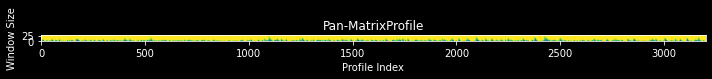

In [5]:
# Calculate MP via MPX algorithm (improvement over STOMP) and store relevant info in a MP data structure

spy_mp = mp.compute(spy_ts, windows = 90)   # look at stock trends in 3 month windows
ge_mp = mp.compute(ge_ts, windows = 30)

# Attempt to calculate the pan-MP (automatically calculates the ideal MP window length for you)
spy_pmp = mp.compute(spy_ts)
best_window = max(spy_pmp['windows'])
mp.visualize(spy_pmp)

In [6]:
# Find discords + motifs in the MP (note we overwrite our MP data struct, adding keys with relevant data)

spy_mp = mp.discover.discords(spy_mp, exclusion_zone=30)
spy_mp = mp.discover.motifs(spy_mp, exclusion_zone=30)
spy_mp = mp.discover.motifs(spy_mp, exclusion_zone=30)

ge_mp = mp.discover.discords(ge_mp, exclusion_zone=15)
ge_mp = mp.discover.motifs(ge_mp, exclusion_zone=15)
ge_mp = mp.discover.regimes(ge_mp,3)

spy_pmp = mp.discover.discords(spy_pmp, exclusion_zone = best_window)
# Note that discords are tuples for PMP, first num locates proper MP and second is actual x value of discord
# How to choose WHICH PMP we want to use??
spy_pmp = mp.discover.motifs(spy_pmp, exclusion_zone = best_window)
spy_pmp = mp.discover.motifs(spy_pmp, exclusion_zone = best_window)

spy_mp

{'mp': array([6.27240625, 6.32366961, 6.34199213, ..., 2.95733785, 2.93595132,
        2.83071652]),
 'pi': array([2623, 2624, 2625, ..., 1349, 2906, 2906]),
 'rmp': None,
 'rpi': None,
 'lmp': None,
 'lpi': None,
 'metric': 'euclidean',
 'w': 90,
 'ez': 0,
 'join': False,
 'sample_pct': 1,
 'data': {'ts': array([105.79, 105.08, 105.62, ..., 259.11, 258.17, 258.09]),
  'query': None},
 'class': 'MatrixProfile',
 'algorithm': 'mpx',
 'discords': array([2548, 1312, 2868]),
 'motifs': [{'motifs': [376, 1946],
   'neighbors': [1702, 1430, 1376, 345, 2147, 1087, 2932, 1837, 3044, 33]},
  {'motifs': [2734, 2920],
   'neighbors': [2287, 500, 146, 2972, 1001, 2640, 2820, 2004, 1226, 2402]},
  {'motifs': [409, 1389],
   'neighbors': [1121, 3079, 1032, 2243, 2035, 1463, 2318, 3110, 177, 3003]}]}

In [7]:
spy_pmp

{'pmp': array([[0.48717185, 0.30857764, 0.38035287, ...,        inf,        inf,
                inf],
        [0.49584495, 0.41594435, 0.88312672, ...,        inf,        inf,
                inf],
        [0.56774531, 1.10845855, 1.29611751, ...,        inf,        inf,
                inf],
        ...,
        [1.94462084, 2.17025363, 2.25110139, ...,        inf,        inf,
                inf],
        [2.20235766, 2.26777287, 2.20833226, ...,        inf,        inf,
                inf],
        [2.29322815, 2.22316519, 2.32938449, ...,        inf,        inf,
                inf]]),
 'pmpi': array([[                2311,                 2312,                 2313,
         ..., -9223372036854775808, -9223372036854775808,
         -9223372036854775808],
        [                2311,                 2312,                 1921,
         ..., -9223372036854775808, -9223372036854775808,
         -9223372036854775808],
        [                2311,                 1920,            

In [8]:
print(f"PMP computed {len(spy_pmp['pmp'])} profiles")

PMP computed 29 profiles


Motif starts at: 376
Motif starts at: 1946


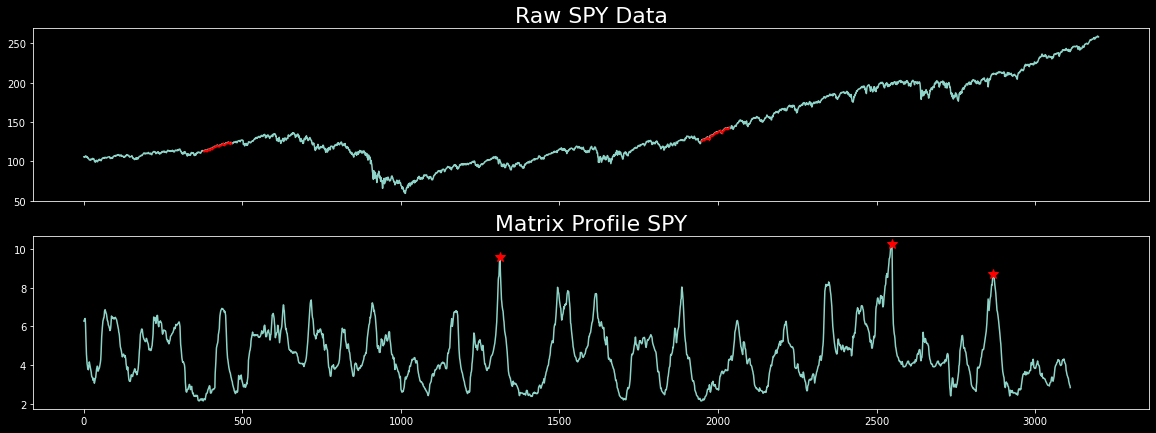

In [9]:
# Create a plot with 2 subplots
fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(20,7))

# Evenly spaced x values across range of our time series data
x = np.arange(len(spy_mp['data']['ts']))

ax1.plot(x, spy_mp['data']['ts'])
ax1.set_title('Raw SPY Data', size=22)

# Plot the Matrix Profile, note we zero-pad MP to match length of time series
mp_adjusted = np.append(spy_mp['mp'], np.zeros(spy_mp['w'] - 1) + np.nan)
ax2.plot(np.arange(len(mp_adjusted)), mp_adjusted)
ax2.set_title('Matrix Profile SPY', size=22)

# Lastly, mark discords with stars 
for discord in spy_mp['discords']:
    x = discord
    y = spy_mp['mp'][discord]

    ax2.plot(x, y, marker='*', markersize=10, c='r')
    
# Now mark motifs in the original data series
# Motifs designate PAIRS of conserved structure in the original data series 
motif_indices = spy_mp['motifs'][0]['motifs']
window = 90

# Place markers on window-sized segments following each motif's starting index 
for motif in motif_indices:
    x = motif
    print(f"Motif starts at: {x}")
    while x < (motif+window):
        y = spy_mp['data']['ts'][x]
        ax1.plot(x, y, marker = '*', markersize=1, c='r')
        x += 1

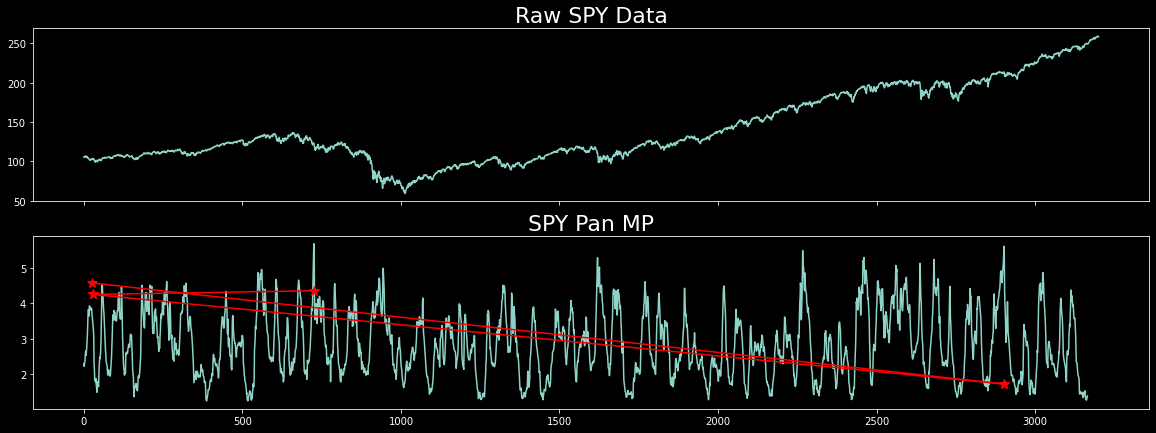

In [10]:
# Plot out the last pan MP to see how it compares
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(20,7))
ax1.plot(np.arange(len(spy_pmp['data']['ts'])), spy_pmp['data']['ts'])
ax1.set_title('Raw SPY Data', size=22)

# Plot the Pan Matrix Profile
mp_adjusted = np.append(spy_pmp['pmp'][-1], np.zeros(max(spy_pmp['windows']) - 1) + np.nan)
ax2.plot(np.arange(len(mp_adjusted)), mp_adjusted)
ax2.set_title('SPY Pan MP', size=22)

# mark discords with stars
for discord in spy_pmp['discords']:
    x = discord
    y = ge_mp['mp'][discord]

    ax2.plot(x, y, marker='*', markersize=10, c='r')